# 2 - Convert from geographical space to image space     🗺️ --> 🖼️
**OBJECTIVE:**  converting the bounding box coordinates in the annotated vector (geoJSON) files from map (UTM coordinates) to image coordinates in the **YOLO format** (*.txt). This allows us to proceed to training the model in the next few steps.

**INPUT:** 
- `path_to_tiles` = path to directory where image tiles from step 1 were stored 
- `path_to_annotations` = path to polygon geojson file containing the manually annotated bounding boxes. This file should contain the `treeID` and `class` columns.
- `path_to_tile_index` = path to tile index that includes the tiles above

**OUTPUT:** 
- Folder with both image tiles (.tif) and corresponding annotations (.txt).


In [ ]:
#annotator_ID=full_data # change this to your folder ID

path_to_tiles="/content/drive/MyDrive/NOVA_course_deep_learning_Original/data/annotated_data/train/full_data/all_data"  
path_to_annotations="/content/drive/MyDrive/NOVA_course_deep_learning_Original/data/annotated_data/train/full_data/full_annotations"+".shp"
path_to_tile_index="/content/drive/MyDrive/NOVA_course_deep_learning_Original/data/map_data/train_data_tile_index.geojson"


# Define the class names and their corresponding IDs
class_names = ['tree']
class_ids = {'tree': 0}

In [ ]:
path_to_tile_index

'/content/drive/MyDrive/NOVA_course_deep_learning_Original/data/map_data/train_data_tile_index.geojson'

## A refresher on the YOLO format?
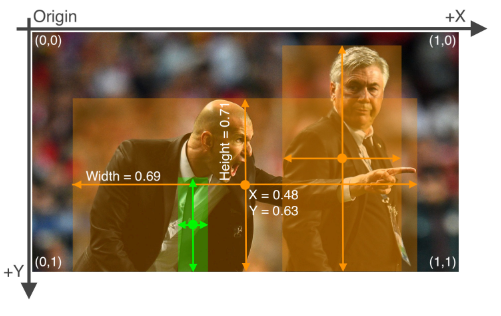
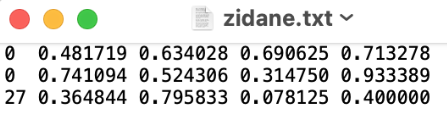

In the YOLO format, each training image is paired with a corresponding text file with the same name as the image, but with a ".txt" extension. The text file contains one row for each object detected in the image. Each row contains the following values separated by spaces:

**Object class index**: An integer representing the object class. This is a zero-indexed value, so the first object class is assigned an index of 0, the second class an index of 1, and so on.

**Object center x-coordinate**: A float representing the x-coordinate of the object's center relative to the width of the image.

**Object center y-coordinate**: A float representing the y-coordinate of the object's center relative to the height of the image.

**Object width**: A float representing the width of the object relative to the width of the image.

**Object height**: A float representing the height of the object relative to the height of the image.

Each row in the text file corresponds to an object detected in the image. Therefore, the number of rows in the text file will vary depending on the number of objects detected in the image. The YOLO format allows for multiple objects of different classes to be detected in a single image.




## 2.1 import libraries and mount google drive

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.3 MB/s eta 0:00:00


In [ ]:
import os, glob, json
import numpy as np

# geospatial packages
import geopandas as gpd

# plotting libraries
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# create output dir in drive
#if not os.path.exists(out_dir):
#    os.makedirs(out_dir)  

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


## 2.2 Load annotations (.geojson) and tile index


In [ ]:
# Read the annotations (.geojson) using geopandas
annotations = gpd.read_file(path_to_annotations)
# add class
annotations['class']='tree'

# Read the (.shp) file using geopandas
tile_index=gpd.read_file(path_to_tile_index)



In [ ]:
# subset the tile index to include only tiles that are in the path_to_tiles
tiles_imgs=glob.glob(path_to_tiles+"/*.tif")
tiles_names = [os.path.basename(path) for path in tiles_imgs]
tile_index=tile_index[tile_index['ID'].isin(tiles_names)]


Plot the annotations and tile index for a sanity check

In [ ]:
#fig, ax = plt.subplots(figsize=(5, 5))
#tile_index.plot(ax=ax, edgecolor="black",facecolor="none")
#annotations.plot(ax=ax, edgecolor="red",facecolor="none")

## 2.3 Iterate through each of the tiles and export YOLO annotations for each tile (if annotations are available within that tile) 
For ease of understanding here we will use a nested for loop to iterate through each  tile `i` and each annotation `j` within tile `i`

In [16]:
for i, tile in tile_index.iterrows(): 
  # iterate through all rows in tile index
  filename=tile['ID'] # get filename

  # get tile polygon
  tile_poly=tile_index[tile_index['ID']==filename]

  # select annotations that intersect with the ith tile
  ann_in_tile = gpd.sjoin(
    annotations,
    tile_poly,
    how='inner',
    predicate='intersects',
  ) 
  #ann_in_tile = annotations[annotations.intersects(tile.geometry)]
  
  # skip iteration if there are no annotations in a tile
  if len(ann_in_tile)==0:
    continue
  
  # get image size metadata
  #imgs= glob.glob(path_to_tiles+"/*.tif") # search for all .tif files in path_to_tiles
  if not os.path.exists(path_to_tiles+"/" + filename):
    print("skip")
    continue
  try:
    one_img= Image.open(path_to_tiles+"/" + filename) # read in the first one
  except:
    print("file corrupted")
    continue
  one_img_array = np.array(one_img) # convert to a numpy array
  # get image width and height
  img_height_px= one_img_array.shape[0]
  img_width_px= one_img_array.shape[1]

  # Define the output file path
  output_file = path_to_tiles+"/"+os.path.splitext(filename)[0]+'.txt'

  # Open the output file for writing
  with open(output_file, 'w') as f:
    # Iterate through each polygon (j= 1,2,3,...) in the GeoJSON file
    for j, ann in ann_in_tile.iterrows():
      if ann['geometry'].geom_type == 'Polygon':
        polygons = [ann['geometry']]
      else:
        polygons = ann['geometry'].geoms

      # iterate through each vertex in the annotated bounding box
      for polygon in polygons:
        vertices = polygon.exterior.coords[:]
        
        # get tile extent
        tile_min_x, tile_min_y, tile_max_x, tile_max_y = tile['geometry'].bounds
        tile_width_m = round(tile_max_x - tile_min_x)
        tile_height_m = round(tile_max_y - tile_min_y)     
         
        # get UTM coordinates of bounding box centre
        center_x_UTM = sum(coord[0] for coord in vertices) / len(vertices)
        center_y_UTM = sum(coord[1] for coord in vertices) / len(vertices)

        # convert them to coordinates relative to the tile size with origin 0, 0 in the upper left corner
        center_x= center_x_UTM - tile_min_x
        center_y= (tile_max_y-center_y_UTM)

        # get tile width and height in m
        min_x, min_y, max_x, max_y = polygon.bounds
        width_m = max_x - min_x
        height_m = max_y - min_y

        # Convert the coordinates to YOLO format
        x = center_x / tile_width_m
        y = center_y / tile_height_m
        w = width_m/tile_width_m    
        h = height_m/tile_height_m

        # replace negative values with zeros
        if x <0: x=0
        if y <0:y=0
        if w <0: w=0
        if h <0: h=0

        # replace values >1 values with 1
        if x >1: x=1
        if y >1:y=1
        if w >1: w=1
        if h >1: h=1
        
        # assign class ID (YOLO needs the classes to be numeric!)
        class_id = class_ids[ann['class']]

        # Write the annotation to the output file
        f.write(f"{class_id} {x} {y} {w} {h}\n")

file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted
file corrupted


## 2.4 Plot the annotations overlayed to the ortho tile make sure that the export was correct

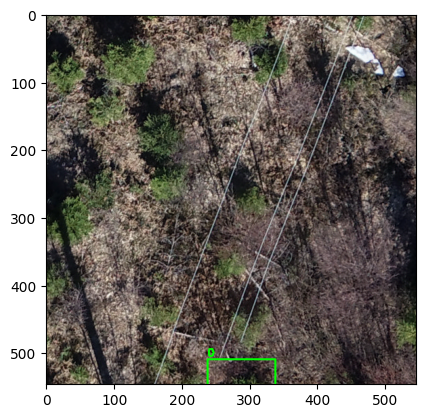

In [18]:
# read in one of the annotation files
annotation_plot_path= glob.glob(path_to_tiles+"/*.txt")[6]
filename_plot=os.path.splitext(os.path.basename(annotation_plot_path))[0]
with open(annotation_plot_path, "r") as f:
    annotations = f.readlines()

# read in the corresponding image tile
image_tile_plot  = cv2.imread(path_to_tiles+"/"+filename_plot+".tif")

# Parse annotations
annotations = [annotation.strip().split() for annotation in annotations]
annotations = [(annotation[0], float(annotation[1]), float(annotation[2]), float(annotation[3]), float(annotation[4])) for annotation in annotations]

# Overlay annotations on image
for annotation in annotations:
    label, x, y, w, h = annotation
    x1 = int((x - w/2) * image_tile_plot.shape[1])
    y1 = int((y - h/2) * image_tile_plot.shape[0])
    x2 = int((x + w/2) * image_tile_plot.shape[1])
    y2 = int((y + h/2) * image_tile_plot.shape[0])
    cv2.rectangle(image_tile_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_tile_plot, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Plot image
plt.imshow(cv2.cvtColor(image_tile_plot, cv2.COLOR_BGR2RGB))
plt.show()


If the image above looks ok then you are done!

# The End 👍